# Movies

- Data Cleaning
- Descriptive Statistics
- Grouping by Proxies
- Selecting Specific Items

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone

%matplotlib inline

In [2]:
# Reading the data from movies revisions and movies items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/movies_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/movies.csv')

In [3]:
print("Number of Revisions in Movies Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Movies Dataset")
print(items.shape)

Number of Revisions in Movies Dataset
(1730873, 12)
Number of Wikidata Items in Movies Dataset
(381030, 3)


# Data Cleaning

In [4]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [5]:
# Method to assign edit types to each revision by using the revision comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # c = comment.decode("utf-8").lower()
    
    # Converting the comment to lowercase
    c = comment.lower()
    edit_type = '' 
    
    if c == '':
        return edit_type
    
    if "|" in c:
        # Comments which have |
        # Extracting initial edit summary and removing /*
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            edit_type = 'undo'
            return edit_type
        elif 'restore' in cc:
            edit_type = 'restore'
            return edit_type
        elif 'wbsetclaimvalue' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbsetlabeldescriptionaliases' in cc:
            edit_type = 'set'
            return edit_type
        elif 'wbcreateredirect' in cc:
            edit_type = 'create'
            return edit_type
        elif 'merge' in cc:
            edit_type = 'merge'
            return edit_type
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                edit_type = 'create'
                return edit_type
            elif 'add' in ccc:
                edit_type = 'add'
                return edit_type
            elif 'set' in ccc:
                edit_type = 'set'
                return edit_type
            elif 'update' in ccc:
                edit_type = 'update'
                return edit_type
            elif 'remove' in ccc:
                edit_type = 'remove'
                return edit_type
    if 'revert' in c: 
        edit_type = 'revert'
        return edit_type  
    elif 'protect' in c:
        edit_type = 'protect'
        return edit_type  
    elif 'undid' in c:
        edit_type = 'undo'
        return edit_type      
    return edit_type
        

In [6]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [7]:
rev.shape

(1730873, 9)

In [8]:
# Removing revisions with empty types - empty comments or edge cases
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [9]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [10]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    # Remove preceeding b from storing as a bytes object
    # Replace ' with empty character
    u = user[1:].replace("'", "")
    
    user_type = ''
    
    if u == "":
        user_type = 'Anonymous'
        return user_type
    elif u in bots.values:
        user_type = 'Bot'
        return user_type
    else: 
        user_type = 'Registered'
        return user_type
    return user_type
    

In [11]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [12]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [13]:
editscount = rev['qid'].value_counts()

In [14]:
editscount.describe()

count    380601.000000
mean          4.526499
std           5.082929
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         553.000000
Name: qid, dtype: float64

In [15]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [16]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
74058
Items with No of Edits = 2
84341
Items with No of Edits = 3
58174
Items with No of Edits = 4
40783
Items with No of Edits = 5
28859
Items with No of Edits <= 5
286215


In [17]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [18]:
df_editscount.shape

(94386, 2)

In [19]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [20]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [21]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [22]:
print(df_editscount.head())
print(rev[rev['qid'] == 'Q4115189'])
print(rev[rev['qid'] == 'Q52'])
print(rev[rev['qid'] == 'Q2013'])

         qid  editscount
0       Q886         553
1  Q19590955         530
2     Q22686         456
3    Q348037         336
4  Q18647981         327
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []


In [23]:
print("Number of Revisions in Movies Dataset after Data Cleaning")
print(rev.shape)
print("Number of Wikidata Items in Movies Dataset after Data Cleaning")
movies_items = rev['qid'].value_counts()
print(movies_items.shape)

Number of Revisions in Movies Dataset after Data Cleaning
(998101, 10)
Number of Wikidata Items in Movies Dataset after Data Cleaning
(94386,)


# Descriptive Statistics

In [24]:
print(movies_items.describe().astype(int))

count    94386
mean        10
std          7
min          6
25%          7
50%          9
75%         13
max        553
Name: qid, dtype: int32


In [25]:
# converting a series to a dataframe
m_items = pd.DataFrame({'type':movies_items.index, 'count':movies_items.values})

In [26]:
# Items between the median and 75th percentile
print(m_items[(m_items['count'] >= 9) & (m_items['count'] < 14)])
# Items in the top 25% of the dataset
print(m_items[m_items['count'] >= 13])
# Items below median that is items that fall in the fist 50%
print(m_items[m_items['count'] < 9])
# Items that form the low 25% of the dataset
print(m_items[m_items['count'] < 7])
# Items that are part of 75% of the dataset
print(m_items[m_items['count'] < 13])

            type  count
19977   Q2979232     13
19978   Q1166240     13
19979  Q25999723     13
19980   Q1267508     13
19981   Q1785725     13
...          ...    ...
50433  Q25136417      9
50434    Q151895      9
50435   Q2807449      9
50436  Q27888457      9
50437   Q3234816      9

[30461 rows x 2 columns]
            type  count
0           Q886    553
1      Q19590955    530
2         Q22686    456
3        Q348037    336
4      Q18647981    327
...          ...    ...
24490  Q15731912     13
24491   Q2713624     13
24492    Q934004     13
24493    Q472034     13
24494   Q3020363     13

[24495 rows x 2 columns]
            type  count
50438   Q5998628      8
50439   Q3055315      8
50440   Q3828476      8
50441   Q5969959      8
50442  Q24897040      8
...          ...    ...
94381  Q19363902      6
94382    Q139611      6
94383  Q13527029      6
94384  Q16252090      6
94385   Q6782086      6

[43948 rows x 2 columns]
            type  count
74456   Q3831500      6
74457   Q7

# Statistics for Proxies

In [27]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [28]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

          count
type           
create   591335
add      300898
update    46009
remove    28292
set       27699
merge      1726
revert     1009
undo        807
restore     313
protect      13


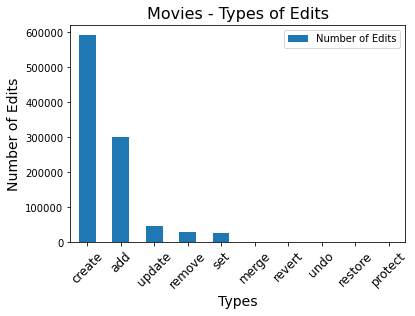

In [29]:
# Plotting the statistics for the proxies in the dataset
ax = ts.plot.bar()

plt.title('Movies - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [31]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

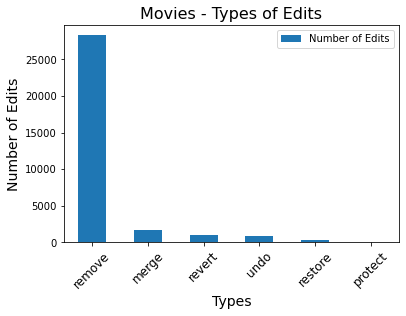

In [32]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Movies - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

In [33]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
merge     1726
revert    1009
undo       807
restore    313
protect     13


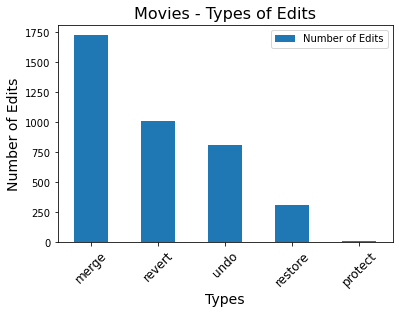

In [34]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Movies - Types of Edits', fontsize=16)
plt.xlabel('Types', fontsize=14)
plt.ylabel('Number of Edits', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
ax.legend(['Number of Edits'])

plt.show()

# Statistics for No of Edits

In [35]:
no_of_edits = movies_items.to_numpy()

(array([6.4661e+04, 1.9879e+04, 7.3590e+03, 1.3460e+03, 5.2200e+02,
        2.0100e+02, 1.4700e+02, 4.7000e+01, 5.3000e+01, 2.3000e+01,
        2.7000e+01, 1.8000e+01, 1.5000e+01, 1.1000e+01, 1.2000e+01,
        1.2000e+01, 8.0000e+00, 6.0000e+00, 5.0000e+00, 2.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

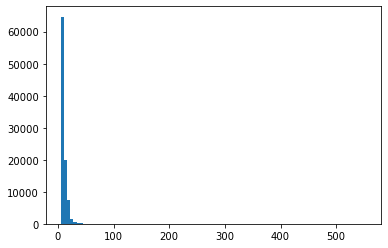

In [36]:
# Exploring distribution of number of edits
plt.hist(no_of_edits, 100)

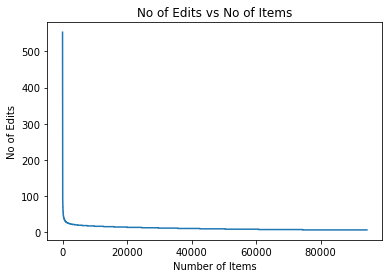

In [37]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

# Grouping by Proxies

In [38]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [39]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [40]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [41]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [42]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [43]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [44]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [45]:
proxies = proxies.reset_index()

In [46]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [47]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [48]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [49]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [50]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [51]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,94386.000000,94386.000000,94386.000000,94386.000000,94386.000000,94386.000000,94386.000000,94386.000000
mean,0.010690,0.018287,0.008550,0.003316,0.000138,0.299748,10.574672,3.978334
std,0.183271,0.139564,0.195139,0.070413,0.011735,0.795319,7.107399,1.848539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,3.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,4.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,5.000000
max,21.000000,3.000000,31.000000,4.000000,1.000000,62.000000,553.000000,122.000000


Text(0, 0.5, 'No of Edits')

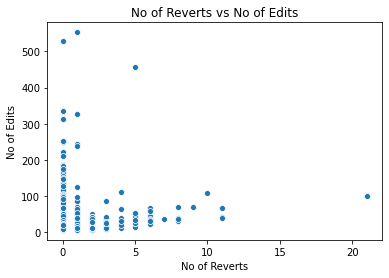

In [52]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")

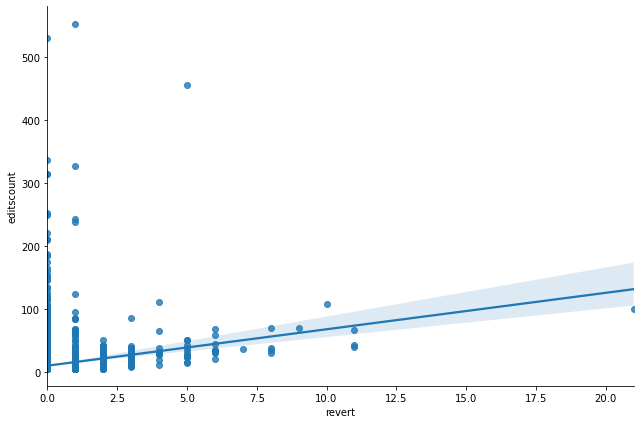

In [54]:
sns.lmplot(x="revert", y="editscount", data=proxies, height=6, aspect=1.5)

In [55]:
corr_matrix = proxies.corr()
corr_matrix

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.017625,0.184379,0.339616,0.319520,0.088792,0.149021,0.183665
merge,0.017625,1.000000,0.042498,0.072532,0.011400,0.107348,0.040942,0.013897
undo,0.184379,0.042498,1.000000,0.139815,0.087391,0.135449,0.168566,0.160646
restore,0.339616,0.072532,0.139815,1.000000,0.217420,0.156685,0.131535,0.116789
protect,0.319520,0.011400,0.087391,0.217420,1.000000,0.030767,0.055324,0.045559
remove,0.088792,0.107348,0.135449,0.156685,0.030767,1.000000,0.269864,0.142812
editscount,0.149021,0.040942,0.168566,0.131535,0.055324,0.269864,1.000000,0.492573
userscount,0.183665,0.013897,0.160646,0.116789,0.045559,0.142812,0.492573,1.000000


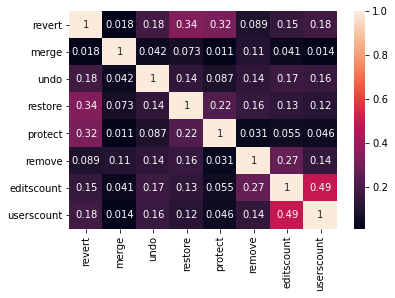

In [56]:
sns.heatmap(corr_matrix, annot=True)

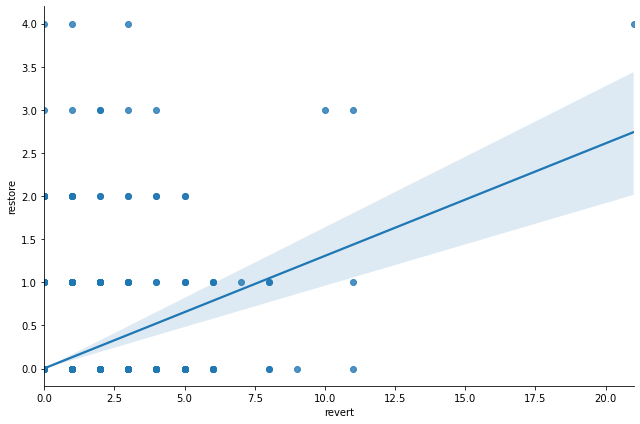

In [57]:
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

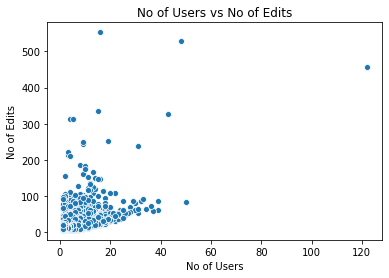

In [58]:
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

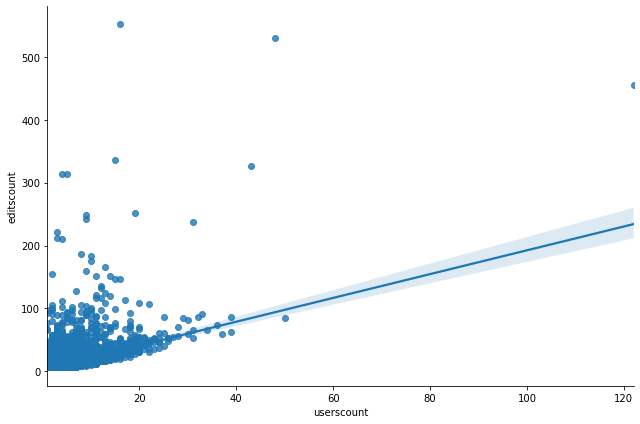

In [59]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=1.5)

In [60]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [61]:
proxies.shape

(22079, 9)

In [62]:
# Items which only have edits under remove and are 0 for the remaining proxies
proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)]

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
4,Q2125700,0,0,0,0,0,1,8,4
33,Q2134387,0,0,0,0,0,1,12,4
47,Q2139572,0,0,0,0,0,2,14,5
48,Q2139961,0,0,0,0,0,1,13,4
63,Q2142323,0,0,0,0,0,1,8,4
...,...,...,...,...,...,...,...,...,...
94109,Q28064160,0,0,0,0,0,1,17,2
94271,Q28070775,0,0,0,0,0,1,28,2
94354,Q28083104,0,0,0,0,0,2,23,1
94364,Q28088612,0,0,0,0,0,3,11,1


In [63]:
# Removing items with only edits under remove
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0)].index
proxies_without_remove = proxies.drop(to_remove)

In [64]:
proxies_without_remove.shape

(2769, 9)

In [65]:
corr = proxies_without_remove.corr()
corr

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.379967,0.109495,0.274284,0.315857,0.087417,0.249815,0.376202
merge,-0.379967,1.000000,-0.231835,-0.208076,-0.060210,-0.003266,-0.113789,-0.296075
undo,0.109495,-0.231835,1.000000,0.076798,0.072891,0.208260,0.302853,0.333338
restore,0.274284,-0.208076,0.076798,1.000000,0.207339,0.248455,0.221320,0.215931
protect,0.315857,-0.060210,0.072891,0.207339,1.000000,0.042878,0.099621,0.092899
remove,0.087417,-0.003266,0.208260,0.248455,0.042878,1.000000,0.441996,0.270381
editscount,0.249815,-0.113789,0.302853,0.221320,0.099621,0.441996,1.000000,0.610513
userscount,0.376202,-0.296075,0.333338,0.215931,0.092899,0.270381,0.610513,1.000000


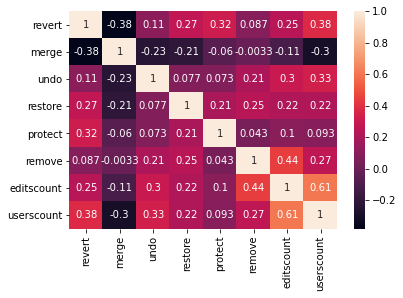

In [66]:
sns.heatmap(corr, annot=True)

# Top 20

## Top 20 Revert

In [67]:
top20_reverts = proxies_without_remove.nlargest(20, 'revert')

In [68]:
top20_reverts

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
25625,Q4120122,21,0,1,4,0,4,100,10
4340,Q1203,11,0,2,1,0,0,67,20
8996,Q550067,11,0,2,3,1,1,43,5
83916,Q18222476,11,0,1,0,0,4,40,13
89500,Q25104182,10,0,4,3,1,8,108,20
4367,Q2831,9,0,0,0,0,5,70,28
4430,Q6691,8,0,0,0,0,4,39,18
4861,Q39476,8,0,0,1,0,5,70,18
6626,Q151892,8,0,0,0,1,2,31,14
20535,Q3626966,8,0,0,1,1,0,36,12


In [69]:
revert_item_labels = ['Ruggero Pasquarelli', 'John Lennon', 'Niurka Marcos', 'Sofia Carson', 'Yuri on Ice',
                     'Michael Jackson', 'Homer', 'Emma Watson', 'Ariana Grande', 'Harry Styles', 
                     'Adam Sandler', 'Shakira', 'Johnny Depp', 'Will Smith', 'Maddie Ziegler', 
                     'Courtney Eaton', 'Lali Espósito', 'Harley Quinn', 'Kylie Jenner', 'Elvis Presley']

# Inserting item labels into revert proxies dataframe
top20_reverts.insert(1, "label", revert_item_labels, True)

In [70]:
top20_reverts

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
25625,Q4120122,Ruggero Pasquarelli,21,0,1,4,0,4,100,10
4340,Q1203,John Lennon,11,0,2,1,0,0,67,20
8996,Q550067,Niurka Marcos,11,0,2,3,1,1,43,5
83916,Q18222476,Sofia Carson,11,0,1,0,0,4,40,13
89500,Q25104182,Yuri on Ice,10,0,4,3,1,8,108,20
4367,Q2831,Michael Jackson,9,0,0,0,0,5,70,28
4430,Q6691,Homer,8,0,0,0,0,4,39,18
4861,Q39476,Emma Watson,8,0,0,1,0,5,70,18
6626,Q151892,Ariana Grande,8,0,0,0,1,2,31,14
20535,Q3626966,Harry Styles,8,0,0,1,1,0,36,12


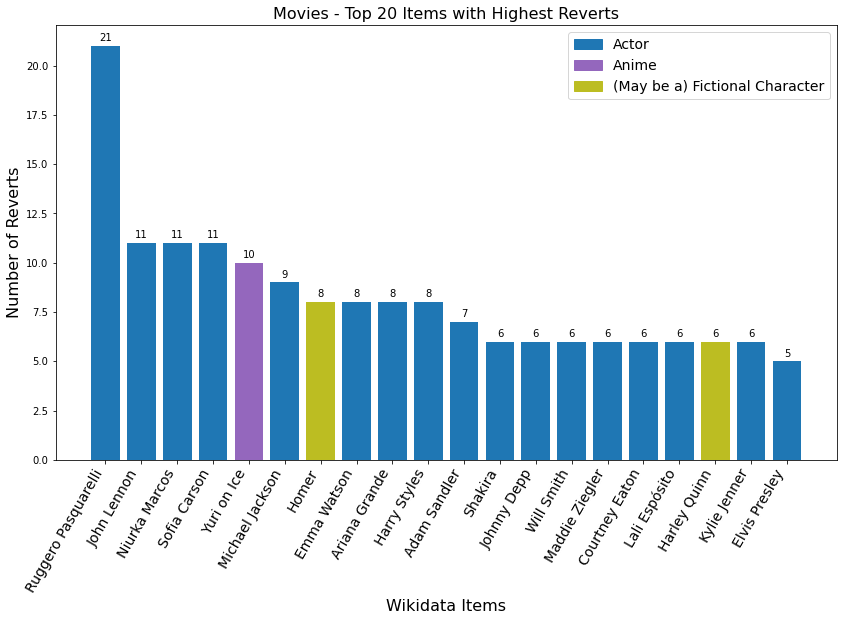

In [71]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_reverts['revert']):
    ax.text(i, r+0.25, str(r), horizontalalignment='center')

colours = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:purple',
           'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:blue', 'tab:blue']

actor = mpatches.Patch(color='tab:blue', label='Actor')
anime = mpatches.Patch(color='tab:purple', label='Anime')
fictional_char = mpatches.Patch(color='tab:olive', label='(May be a) Fictional Character')

plt.legend(handles=[actor, anime, fictional_char], fontsize=14)

plt.bar(top20_reverts['label'], top20_reverts['revert'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Reverts", fontsize=16)
plt.title("Movies - Top 20 Items with Highest Reverts", fontsize=16)
plt.show()

## Top 20 Merges

In [72]:
top20_merges = proxies_without_remove.nlargest(20, 'merge')

In [73]:
top20_merges

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
4477,Q11934,1,3,0,3,0,5,60,11
5566,Q79015,3,3,3,1,0,0,20,5
10208,Q618662,0,3,0,0,0,12,20,2
25842,Q4679171,0,3,0,0,0,2,8,1
39271,Q13091172,0,3,1,3,0,62,184,10
73538,Q1601938,0,3,0,0,0,1,7,1
221,Q2196048,0,2,0,2,0,0,8,1
797,Q2312008,0,2,0,0,0,1,7,1
900,Q2335647,0,2,0,0,0,1,10,1
1353,Q2400208,0,2,0,0,0,1,8,5


In [74]:
merge_item_labels = ['Mickey Mouse', 'Superman', 'Apis', 'Admete', 'Big Hero 6',
                     'Laodamia', 'Creusa', 'Sponde', 'Licymnius', 'Teesri Manzil', 
                     'Corbett and Courtney Before the Kinetograph', 'Captain Rex', 'Iphitus', 'Hesperus', 'Nickelodeon', 
                     'Blacksmith Scene', 'Kim Hyun-joo', 'Antigone of Troy', 'Kam Woo-sung', 'Earth\'s Final Hour ']

# Inserting item labels into merge proxies dataframe
top20_merges.insert(1, "label", merge_item_labels, True)

In [75]:
top20_merges

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
4477,Q11934,Mickey Mouse,1,3,0,3,0,5,60,11
5566,Q79015,Superman,3,3,3,1,0,0,20,5
10208,Q618662,Apis,0,3,0,0,0,12,20,2
25842,Q4679171,Admete,0,3,0,0,0,2,8,1
39271,Q13091172,Big Hero 6,0,3,1,3,0,62,184,10
73538,Q1601938,Laodamia,0,3,0,0,0,1,7,1
221,Q2196048,Creusa,0,2,0,2,0,0,8,1
797,Q2312008,Sponde,0,2,0,0,0,1,7,1
900,Q2335647,Licymnius,0,2,0,0,0,1,10,1
1353,Q2400208,Teesri Manzil,0,2,0,0,0,1,8,5


Text(0.5, 1.0, 'Movies - Top 20 Items with Highest Merges')

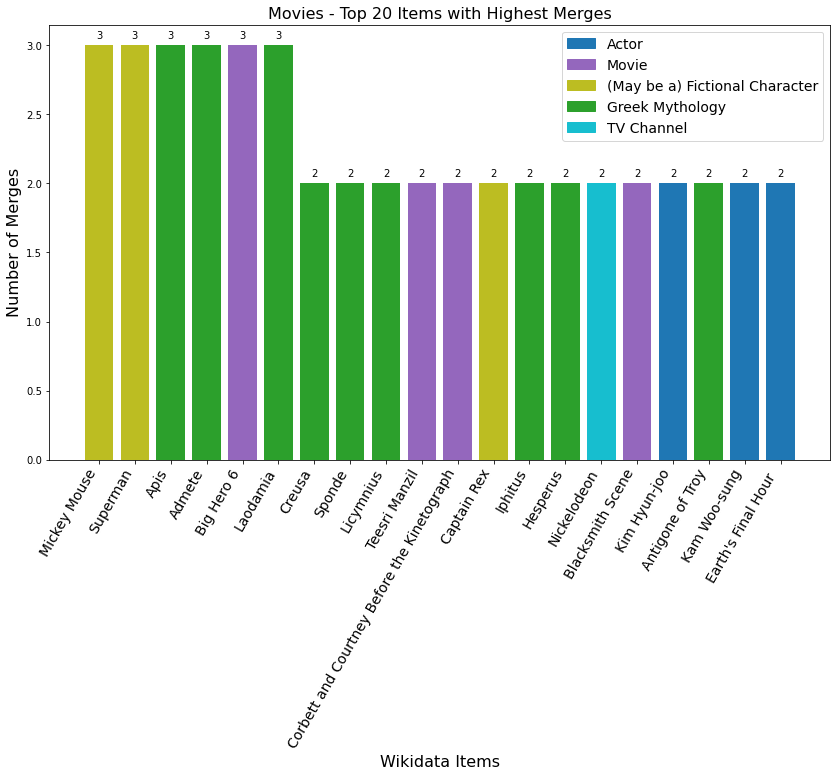

In [77]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_merges['merge']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    

colours = ['tab:olive', 'tab:olive', 'tab:green', 'tab:green', 'tab:purple',
           'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:purple',
           'tab:purple', 'tab:olive', 'tab:green', 'tab:green', 'tab:cyan',
           'tab:purple', 'tab:blue', 'tab:green', 'tab:blue', 'tab:blue']

actor = mpatches.Patch(color='tab:blue', label='Actor')
movie = mpatches.Patch(color='tab:purple', label='Movie')
fictional_char = mpatches.Patch(color='tab:olive', label='(May be a) Fictional Character')
greek_mythology = mpatches.Patch(color='tab:green', label='Greek Mythology')
tv_channel = mpatches.Patch(color='tab:cyan', label='TV Channel')

plt.legend(handles=[actor, movie, fictional_char, greek_mythology, tv_channel], fontsize=14)

plt.bar(top20_merges['label'], top20_merges['merge'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Merges", fontsize=16)
plt.title("Movies - Top 20 Items with Highest Merges", fontsize=16)

## Top 20 Undos

In [78]:
top20_undos = proxies_without_remove.nlargest(20, 'undo')

In [79]:
top20_undos

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
5596,Q80938,0,1,31,0,0,6,114,17
4580,Q22686,5,1,19,2,0,28,456,122
13833,Q1214665,0,0,15,0,0,10,40,3
9014,Q550778,0,0,13,0,0,6,64,11
12065,Q720581,0,0,12,0,0,2,25,12
62403,Q276181,0,0,10,0,0,3,20,7
5652,Q83338,1,0,9,0,0,3,27,11
60353,Q187337,0,0,9,0,0,1,16,7
64637,Q439315,0,0,8,0,0,0,11,3
70343,Q1075796,0,0,8,0,0,1,12,4


In [80]:
undo_item_labels = ['John Travolta', 'Donald Trump', 'Power of Attorney', 'John de Lancie', 'Paul Reubens',
                     'Jim Varney', 'Robin Williams', 'Zelda Williams', 'Jemaine Clement', 'Carlos Alazraqui', 
                     'Mitch Hedberg', 'Charles Fleischer', 'actor', 'Richard Simmons', 'Bob Newhart', 
                     'Melanie Martinez', 'Steve Harvey', 'Draco Malfoy', 'Sirius Black', 'Gellert Grindelwald']

# Inserting item labels into undo proxies dataframe
top20_undos.insert(1, "label", undo_item_labels, True)

In [81]:
top20_undos

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
5596,Q80938,John Travolta,0,1,31,0,0,6,114,17
4580,Q22686,Donald Trump,5,1,19,2,0,28,456,122
13833,Q1214665,Power of Attorney,0,0,15,0,0,10,40,3
9014,Q550778,John de Lancie,0,0,13,0,0,6,64,11
12065,Q720581,Paul Reubens,0,0,12,0,0,2,25,12
62403,Q276181,Jim Varney,0,0,10,0,0,3,20,7
5652,Q83338,Robin Williams,1,0,9,0,0,3,27,11
60353,Q187337,Zelda Williams,0,0,9,0,0,1,16,7
64637,Q439315,Jemaine Clement,0,0,8,0,0,0,11,3
70343,Q1075796,Carlos Alazraqui,0,0,8,0,0,1,12,4


Text(0.5, 1.0, 'Movies - Top 20 Items with Highest Undos')

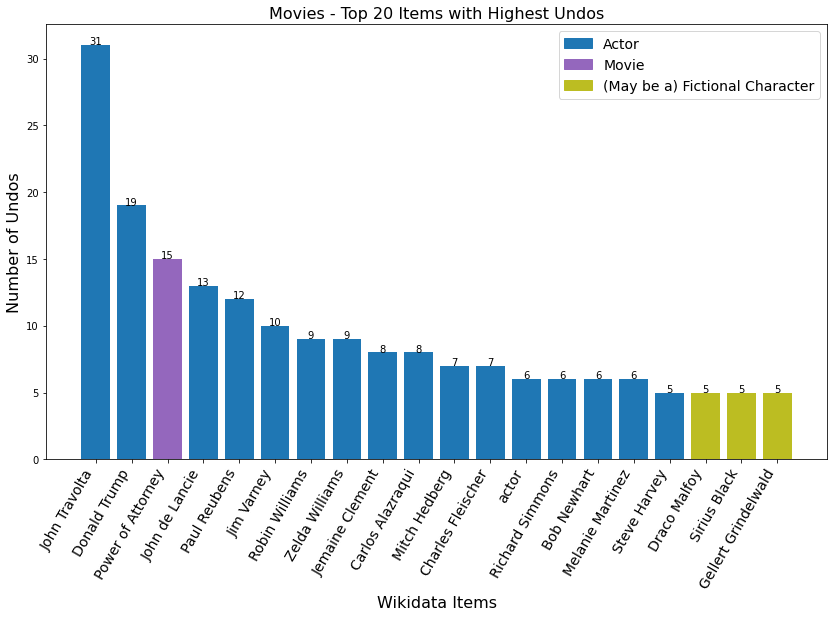

In [82]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_undos['undo']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')
    
colours = ['tab:blue', 'tab:blue', 'tab:purple', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue',
           'tab:blue', 'tab:blue', 'tab:olive', 'tab:olive', 'tab:olive']

actor = mpatches.Patch(color='tab:blue', label='Actor')
movie = mpatches.Patch(color='tab:purple', label='Movie')
fictional_char = mpatches.Patch(color='tab:olive', label='(May be a) Fictional Character')

plt.legend(handles=[actor, movie, fictional_char], fontsize=14)

plt.bar(top20_undos['label'], top20_undos['undo'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Undos", fontsize=16)
plt.title("Movies - Top 20 Items with Highest Undos", fontsize=16)

## Top 20 Restores

In [83]:
top20_restores = proxies_without_remove.nlargest(20, 'restore')

In [84]:
top20_restores

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
5646,Q83161,1,0,2,4,0,15,34,9
25625,Q4120122,21,0,1,4,0,4,100,10
28314,Q5367677,0,0,0,4,0,17,104,9
60899,Q211283,3,0,0,4,0,2,86,11
4477,Q11934,1,3,0,3,0,5,60,11
4483,Q12379,2,0,0,3,0,7,26,11
4793,Q33999,4,0,6,3,0,2,65,34
8996,Q550067,11,0,2,3,1,1,43,5
39271,Q13091172,0,3,1,3,0,62,184,10
46491,Q18697302,2,0,0,3,0,1,17,7


In [85]:
restore_item_labels = ['Charlotte\'s Web 2', 'Ruggero Pasquarelli', 'Japan\'s Longest Day', 'Bob Hoskins', 'Mickey Mouse',
                     'Mario', 'actor', 'Niurka Marcos', 'Big Hero 6', 'Kristina Pimenova', 
                     'Cheryl', 'Yuri on Ice', 'Creusa', '\"Weird Al\" Yankovic', 'Thomas Alva Edison', 
                     'Donald Trump', 'Selena Gomez', 'George Carlin', 'Marcel Marceau', 'Hermione Granger']

# Inserting item labels into restore proxies dataframe
top20_restores.insert(1, "label", restore_item_labels, True)

In [86]:
top20_restores

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
5646,Q83161,Charlotte's Web 2,1,0,2,4,0,15,34,9
25625,Q4120122,Ruggero Pasquarelli,21,0,1,4,0,4,100,10
28314,Q5367677,Japan's Longest Day,0,0,0,4,0,17,104,9
60899,Q211283,Bob Hoskins,3,0,0,4,0,2,86,11
4477,Q11934,Mickey Mouse,1,3,0,3,0,5,60,11
4483,Q12379,Mario,2,0,0,3,0,7,26,11
4793,Q33999,actor,4,0,6,3,0,2,65,34
8996,Q550067,Niurka Marcos,11,0,2,3,1,1,43,5
39271,Q13091172,Big Hero 6,0,3,1,3,0,62,184,10
46491,Q18697302,Kristina Pimenova,2,0,0,3,0,1,17,7


Text(0.5, 1.0, 'Movies - Top 20 Items with Highest Restores')

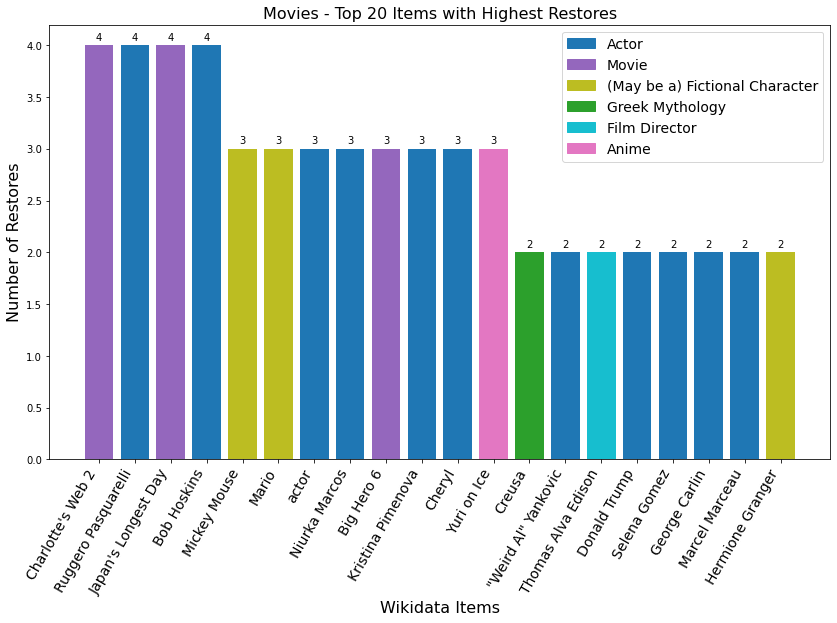

In [88]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_restores['restore']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')

    
colours = ['tab:purple', 'tab:blue', 'tab:purple', 'tab:blue', 'tab:olive',
           'tab:olive', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:blue',
           'tab:blue', 'tab:pink', 'tab:green', 'tab:blue', 'tab:cyan',
           'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:olive']

actor = mpatches.Patch(color='tab:blue', label='Actor')
movie = mpatches.Patch(color='tab:purple', label='Movie')
fictional_char = mpatches.Patch(color='tab:olive', label='(May be a) Fictional Character')
greek_mythology = mpatches.Patch(color='tab:green', label='Greek Mythology')
film_director = mpatches.Patch(color='tab:cyan', label='Film Director')
anime = mpatches.Patch(color='tab:pink', label='Anime')

plt.legend(handles=[actor, movie, fictional_char, greek_mythology, film_director, anime], fontsize=14)

plt.bar(top20_restores['label'], top20_restores['restore'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Restores", fontsize=16)
plt.title("Movies - Top 20 Items with Highest Restores", fontsize=16)

## Top 20 Edits

In [89]:
top20_edits = proxies_without_remove.nlargest(20, 'editscount')

In [90]:
top20_edits

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
4335,Q886,1,1,1,0,0,4,553,16
4580,Q22686,5,1,19,2,0,28,456,122
46399,Q18647981,1,0,0,0,0,15,327,43
5571,Q79784,1,0,0,0,0,2,243,9
45947,Q18406872,1,0,0,0,0,4,238,31
39271,Q13091172,0,3,1,3,0,62,184,10
4446,Q8539,0,1,0,0,0,0,160,9
30444,Q6031433,0,1,1,0,0,11,147,16
8764,Q537407,1,0,0,0,0,9,124,13
5596,Q80938,0,1,31,0,0,6,114,17


In [91]:
edit_item_labels = ['The Simpsons', 'Donald Trump', 'Moana', 'Friends', 'Doctor Strange',
                     'Big Hero 6', 'The Big Bang Theory', 'Maddie Taylor', 'Mulan', 'John Travolta', 
                     'Alfredo Jaar', 'Yuri on Ice', 'Japan\'s Longest Day', 'Ruggero Pasquarelli', 'Snow White and the Seven Dwarfs',  
                     'Tarzan', 'Angelina Jolie', 'The Dragonfly Is Not a Insect', 'The Former Mattia Pascal', 'Westworld']

# Inserting item labels into edit proxies dataframe
top20_edits.insert(1, "label", edit_item_labels, True)

In [92]:
top20_edits

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
4335,Q886,The Simpsons,1,1,1,0,0,4,553,16
4580,Q22686,Donald Trump,5,1,19,2,0,28,456,122
46399,Q18647981,Moana,1,0,0,0,0,15,327,43
5571,Q79784,Friends,1,0,0,0,0,2,243,9
45947,Q18406872,Doctor Strange,1,0,0,0,0,4,238,31
39271,Q13091172,Big Hero 6,0,3,1,3,0,62,184,10
4446,Q8539,The Big Bang Theory,0,1,0,0,0,0,160,9
30444,Q6031433,Maddie Taylor,0,1,1,0,0,11,147,16
8764,Q537407,Mulan,1,0,0,0,0,9,124,13
5596,Q80938,John Travolta,0,1,31,0,0,6,114,17


Text(0.5, 1.0, 'Movies - Top 20 Items with Highest Edits')

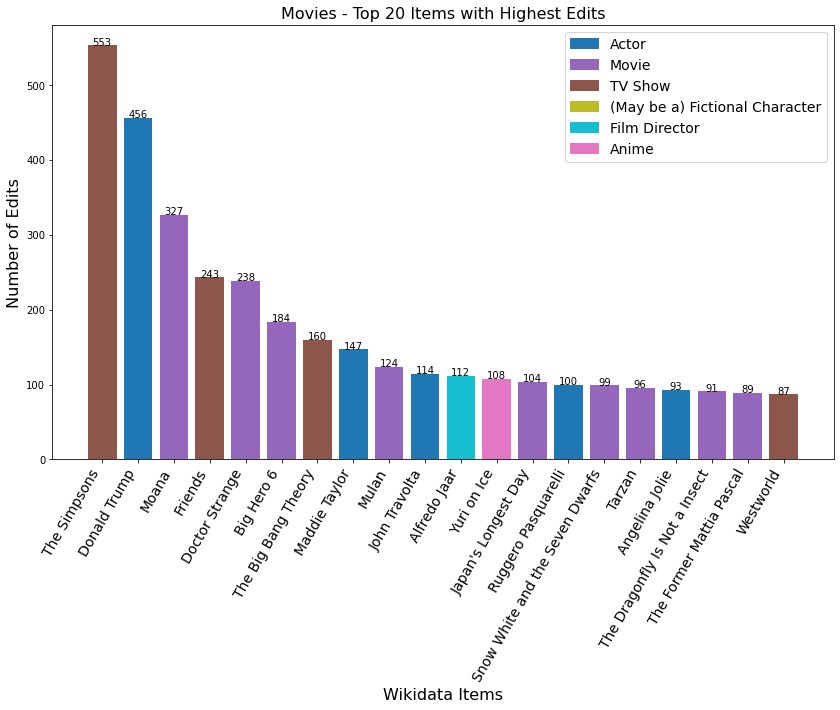

In [97]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_edits['editscount']):
    ax.text(i, r+0.5, str(r), horizontalalignment='center')

    
colours = ['tab:brown', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:purple',
           'tab:purple', 'tab:brown', 'tab:blue', 'tab:purple', 'tab:blue',
           'tab:cyan', 'tab:pink', 'tab:purple', 'tab:blue', 'tab:purple',
           'tab:purple', 'tab:blue', 'tab:purple', 'tab:purple', 'tab:brown']

actor = mpatches.Patch(color='tab:blue', label='Actor')
movie = mpatches.Patch(color='tab:purple', label='Movie')
tv_show = mpatches.Patch(color='tab:brown', label='TV Show')
fictional_char = mpatches.Patch(color='tab:olive', label='(May be a) Fictional Character')
film_director = mpatches.Patch(color='tab:cyan', label='Film Director')
anime = mpatches.Patch(color='tab:pink', label='Anime')

plt.legend(handles=[actor, movie, tv_show, fictional_char, film_director, anime], fontsize=14)

plt.bar(top20_edits['label'], top20_edits['editscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Edits", fontsize=16)
plt.title("Movies - Top 20 Items with Highest Edits", fontsize=16)

## Top 20 Users

In [98]:
top20_users = proxies_without_remove.nlargest(20, 'userscount')

In [99]:
top20_users

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
4580,Q22686,5,1,19,2,0,28,456,122
4324,Q392,1,0,1,1,0,6,84,50
46399,Q18647981,1,0,0,0,0,15,327,43
41237,Q16146870,1,1,0,0,0,0,62,39
45431,Q17572811,0,0,5,0,0,6,87,39
49956,Q21697406,0,1,0,0,0,2,59,37
88419,Q24053263,0,1,1,0,0,1,73,36
4793,Q33999,4,0,6,3,0,2,65,34
47202,Q19321019,1,0,0,0,0,2,86,32
37327,Q10350033,0,0,1,1,0,1,53,31


In [100]:
user_item_labels = ['Donald Trump', 'Bob Dylan', 'Moana', 'Steve Bannon', 'Westworld',
                     'Your Name.', 'Logan', 'actor', 'Miss Peregrine\'s Home for Peculiar Children', 'Pirates of the Caribbean', 
                     'Doctor Strange', 'Fantastic Beasts and Where to Find Them', 'Michael Jackson', 'Sing', 'Jesus',  
                     'Elvis Presley', 'Walt Disney', 'Transformers: The Last Knight', 'Charlie Chaplin', 'John Lennon']

# Inserting item labels into user proxies dataframe
top20_users.insert(1, "label", user_item_labels, True)

In [101]:
top20_users

,qid,label,revert,merge,undo,restore,protect,remove,editscount,userscount
4580,Q22686,Donald Trump,5,1,19,2,0,28,456,122
4324,Q392,Bob Dylan,1,0,1,1,0,6,84,50
46399,Q18647981,Moana,1,0,0,0,0,15,327,43
41237,Q16146870,Steve Bannon,1,1,0,0,0,0,62,39
45431,Q17572811,Westworld,0,0,5,0,0,6,87,39
49956,Q21697406,Your Name.,0,1,0,0,0,2,59,37
88419,Q24053263,Logan,0,1,1,0,0,1,73,36
4793,Q33999,actor,4,0,6,3,0,2,65,34
47202,Q19321019,Miss Peregrine's Home for Peculiar Children,1,0,0,0,0,2,86,32
37327,Q10350033,Pirates of the Caribbean,0,0,1,1,0,1,53,31


Text(0.5, 1.0, 'Movies - Top 20 Items with Highest Users')

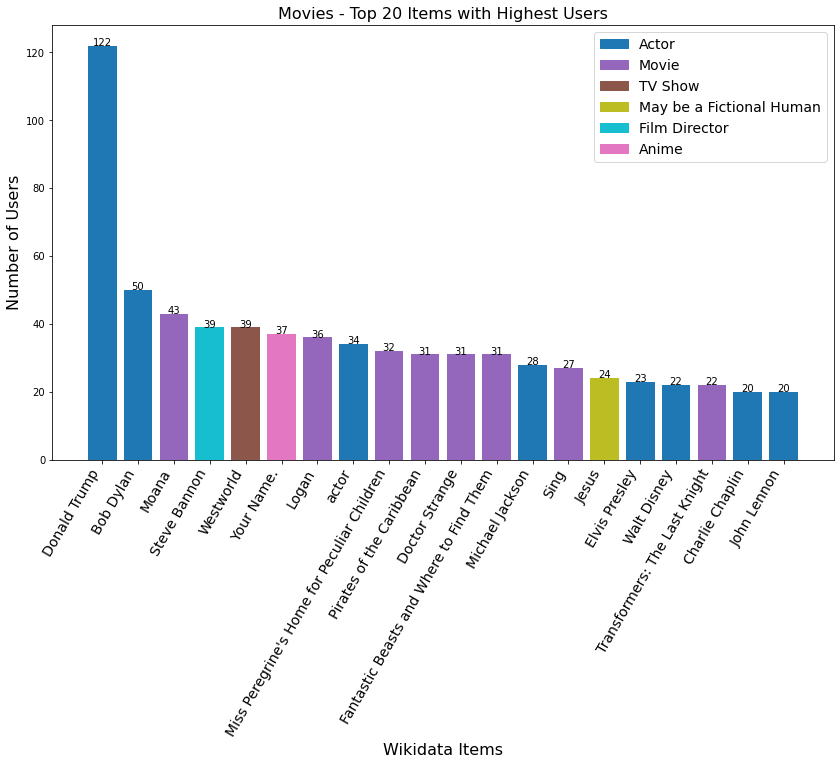

In [103]:
f, ax = plt.subplots(figsize=(14,8))

for i, r in enumerate(top20_users['userscount']):
    ax.text(i, r+0.05, str(r), horizontalalignment='center')


colours = ['tab:blue', 'tab:blue', 'tab:purple', 'tab:cyan', 'tab:brown',
           'tab:pink', 'tab:purple', 'tab:blue', 'tab:purple', 'tab:purple',
           'tab:purple', 'tab:purple', 'tab:blue', 'tab:purple', 'tab:olive',
           'tab:blue', 'tab:blue', 'tab:purple', 'tab:blue', 'tab:blue']

actor = mpatches.Patch(color='tab:blue', label='Actor')
movie = mpatches.Patch(color='tab:purple', label='Movie')
tv_show = mpatches.Patch(color='tab:brown', label='TV Show')
fictional_char = mpatches.Patch(color='tab:olive', label='May be a Fictional Human')
film_director = mpatches.Patch(color='tab:cyan', label='Film Director')
anime = mpatches.Patch(color='tab:pink', label='Anime')

plt.legend(handles=[actor, movie, tv_show, fictional_char, film_director, anime], fontsize=14)

plt.bar(top20_users['label'], top20_users['userscount'], color=colours)
plt.xticks(rotation=60, ha='right', fontsize=14)
plt.xlabel("Wikidata Items", fontsize=16)
plt.ylabel("Number of Users", fontsize=16)
plt.title("Movies - Top 20 Items with Highest Users", fontsize=16)

# Selecting Specific Items

In [104]:
# Finding most commonly occurring items in proxies revert, merge, restore and undo
data_frames = [top20_reverts, top20_merges, top20_undos, top20_restores, top20_edits, top20_users]
common_items = pd.concat(data_frames)

In [105]:
common_items_count = common_items['qid'].value_counts()
common_20 = common_items_count.nlargest(20)
print("Items and the number of times they occurred in top 20 reverts, merges, restores and undos")
print(common_20)

Items and the number of times they occurred in top 20 reverts, merges, restores and undos
Q22686       4
Q25104182    3
Q13091172    3
Q4120122     3
Q33999       3
Q2831        2
Q1203        2
Q2196048     2
Q303         2
Q80938       2
Q18406872    2
Q550067      2
Q18647981    2
Q11934       2
Q5367677     2
Q17572811    2
Q83338       1
Q19321019    1
Q2335647     1
Q2314865     1
Name: qid, dtype: int64


The items selected are:

- Yuri on Ice Q25104182
- Big Hero 6 Q13091172
- The Simpsons Q886

In [106]:
# Storing the revisions of the selected items in CSV files
rev[rev['qid'] == 'Q25104182'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/movies/YuriOnIce_Q25104182.csv')
rev[rev['qid'] == 'Q13091172'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/movies/BigHero6_Q13091172.csv')
rev[rev['qid'] == 'Q886'].to_csv('/Users/tushi/PRJ/WikidataParsing/topics/selected_items/movies/TheSimpsons_Q886.csv')